In [18]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
import datetime
import seaborn as sns
import pickle
%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import data_split
from stock_env import StockTradingEnv
from agents.evn_mvo import StockPortfolioEnv
from portfolio_optimization_env import PortfolioOptimizationEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,trx_plot
from feature_engineer import FeatureEngineer
from models import DRLAgent
from pprint import pprint
import scienceplots
import sys
from finrl.meta.data_processors.func import calc_train_trade_starts_ends_if_rolling

sys.path.append("../FinRL-Library")
import quantstats as qs
plt.style.use('science')
import os
from pypfopt import expected_returns
from agents.mvo_agent import MarkowitzAgent

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.callbacks import EvalCallback


TRAIN_START_DATE = '2000-01-01'
TRAIN_END_DATE = '2022-12-30'
TEST_START_DATE = '2023-01-01'
TEST_END_DATE = '2024-10-01'
from pandas import read_csv
def mvo_data(data, INDICATORS, TEST_START_DATE, TEST_END_DATE):
    final_result = []
    df = data.sort_values(['date', 'tic'], ignore_index=True).copy()
    df.index = df.date.factorize()[0]
    cov_list = []
    mu = []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values
        mu.append(expected_returns.mean_historical_return(price_lookback))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
        {'time': df.date.unique()[lookback:], 'cov_list': cov_list, 'returns': mu})
    df = df.merge(df_cov, left_on='date', right_on='time')

    test_df = data_split(
        df,
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )
    return test_df
def mvo(data, solver='OSQP',window=1, rf=0.02, pct=0.001,objective='min_variance'):
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "window":window

    }
    e_test_gym = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym, rf=rf,objective=objective,cost=pct)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = mvo_min_variance
    result["name"] = 'Min Variance Portfolio'
    return result
def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.date.unique()) - (time_window) - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.index = df_date.date
            account_memory = df_account_value
            actions_memory = df_actions

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory
def train_model(train_data,test_data,evaluation_data,transaction_fee=0.001,use_sharpe=False,use_dsr=False,use_sortino=False,model_name='a2c'
                ,iterations = 100_000,save=True,load=False,tag='tag',features=["close", "log_return"],sharpe_reward = False,t=5,args=None,starting_capital = 250_000,model_path=None,
                comission_fee_model = 'wvm',normalize = "by_previous_time",load_continue=False):
    env_kwargs = {
        "initial_amount": starting_capital, 
        "features" :features,
        'comission_fee_pct':transaction_fee,
        'time_window':t,
        "normalize_df":normalize,
        'comission_fee_model':comission_fee_model,
        "return_last_action" : True
        # 'use_sortino':use_sortino,
        # 'use_differentail_sharpe_ratio':use_dsr,
    }
    train_environment = PortfolioOptimizationEnv(df = train_data, **env_kwargs)
    train_environment._seed(142)

    evaluation_environment = PortfolioOptimizationEnv(df = evaluation_data, **env_kwargs)
    evaluation_environment._seed(142)
    
    test_environment = PortfolioOptimizationEnv(df = test_data, **env_kwargs)
    test_environment._seed(142)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name,
                                  policy = "MultiInputPolicy",
                                  tensorboard_log = './tensorboardlog_'+'_'.join(features)+'_'+tag+'/',
                                  model_kwargs = args)

    checkpoint_callback = CheckpointCallback(save_freq=10000,
                                             save_path='./data/history_main_'+'.'.join(features)+'_'+tag+'/',
                                                 name_prefix=model_name)
    eval_callback = EvalCallback(
        evaluation_environment, 
        best_model_save_path='./data/history_main_'+'.'.join(features)+'_'+tag+'/best',
        log_path='./tensorboardlog_'+'_'.join(features)+'/',              # Path to save evaluation logs
        eval_freq=5000,                            # Evaluate every 5000 steps
        deterministic=True,                        # Use deterministic actions during evaluation
        render=False                               # Don't render the environment during evaluation
    )
    if not load:
        if load_continue == False:
            model = agent.train_model(model=model_agent, 
                            tb_log_name=model_name,
                            total_timesteps=iterations,checkpoint_callback=checkpoint_callback,eval_callbakc=eval_callback)
        else:
            model = model_agent.load(model_path, env =train_environment )
            agent.train_model(model=model, 
                tb_log_name=model_name,
                total_timesteps=iterations,checkpoint_callback=checkpoint_callback,eval_callbakc=eval_callback)
    else:
        print('loading model')
        if model_path == None:
            model = model_agent.load('./data/trained_models_2025/'+str(model_name)+'_'+str(iterations)+'_' + tag)
        else:
            model = model_agent.load(model_path)
    if save and not load:
        model.save('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag )
    metrics_df_dax = pd.DataFrame(
        {
            "date": train_environment._date_memory,
            "actions": train_environment._actions_memory,
            "weights": train_environment._final_weights,
            "returns": train_environment._portfolio_return_memory,
            "rewards": train_environment._portfolio_reward_memory,
            "portfolio_values": train_environment._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(model, test_environment,t)
    results = {'train': metrics_df_dax,'test':ppo_predictions, 'model': model_agent}
    return results
def add_volatility(df, periods=21):
    # Calculate rolling volatility for each ticker without resetting the index
    rolling_volatility = df.groupby('tic')['log_return'].rolling(window=periods).std()
    # Annualize the volatility (scale by sqrt(252))
    annualized_volatility = rolling_volatility * np.sqrt(252)

    # Reset the index to align the multi-level index from rolling with the original DataFrame
    annualized_volatility = annualized_volatility.reset_index(level=0, drop=True)
    # Assign the annualized volatility back to the original DataFrame
    df['volatility'] = annualized_volatility
    
    # Fill missing values with 0 (first periods will have NaN)
    df['volatility'].fillna(0, inplace=True)
    
    return df
    

def plot_weights(result,add_cash,test_data):
    w = pd.DataFrame(result['test'][0].weights.tolist())
    columns = test_data.tic.unique().tolist()
    columns.append('date')
    w['date'] = result['test'][0].date
    if add_cash:
        w.columns = ['cash']+columns
    else:
        w.columns =  columns

    %matplotlib inline
    with plt.style.context('science','ieee'):
        fig, (ax_main, ax_legend) = plt.subplots(
            ncols=2, 
            gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
            figsize=(12, 6)
        )
        w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
        ax_main.set_xlim(w.date.min(), w.date.max())
        ax_main.set_ylim(0, 1)
        ax_main.set_ylabel('Weights')
        ax_main.set_xlabel('Dates')
        ax_legend.axis('off')
        handles, labels = ax_main.get_legend_handles_labels()
        ax_main.legend().remove()
        ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
        plt.tight_layout()
df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')

# Dow Jones Industrial Average
The Dow Jones Industrial Average, Dow Jones, or simply the Dow, is a stock market index of 30 prominent companies listed on stock exchanges in the United States. The DJIA is one of the oldest and most commonly followed equity indexes. 


Constituents: 30

Exchanges: New York Stock Exchange; Nasdaq

Foundation: February 16, 1885; 139 years ago (as DJA); May 26, 1896 (as DJIA)

Market cap: US$12.0 trillion; (as of December 29, 2023)

Trading symbol: ^DJI; $INDU.DJI; DJIA

Weighting method: Price-weighted index

### ENV Creation

In [2]:
df =df_dow.copy()


In [112]:
columns = reduced_data.columns.tolist()
df = df_dow[df_dow.tic.isin(columns)]


In [3]:
TRAIN_START_DATE = '2014-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'
INDICATORS = [
    "rsi",
    "atr",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df.query('date>"2013-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf,0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 29


In [7]:
cleaned_data = cleaned_data[cleaned_data.tic.isin(['AAPL', 'AXP', 'DIS', 'MMM', 'IBM'])]
cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 5


In [111]:
pv = train_data.pivot(columns='tic',values='close')
corr = pv.corr()
data = corr.copy()
high_corr_pairs = set()
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            col_name = corr.columns[i]
            high_corr_pairs.add(col_name)

# Step 3: Drop one of the correlated columns
reduced_data = data.drop(columns=high_corr_pairs)
print("Original columns:", data.columns.tolist())
print("Columns retained after filtering:", reduced_data.columns.tolist())
reduced_data = reduced_data.drop(high_corr_pairs)
reduced_data.style.background_gradient(cmap='coolwarm')

Original columns: ['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']
Columns retained after filtering: ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']


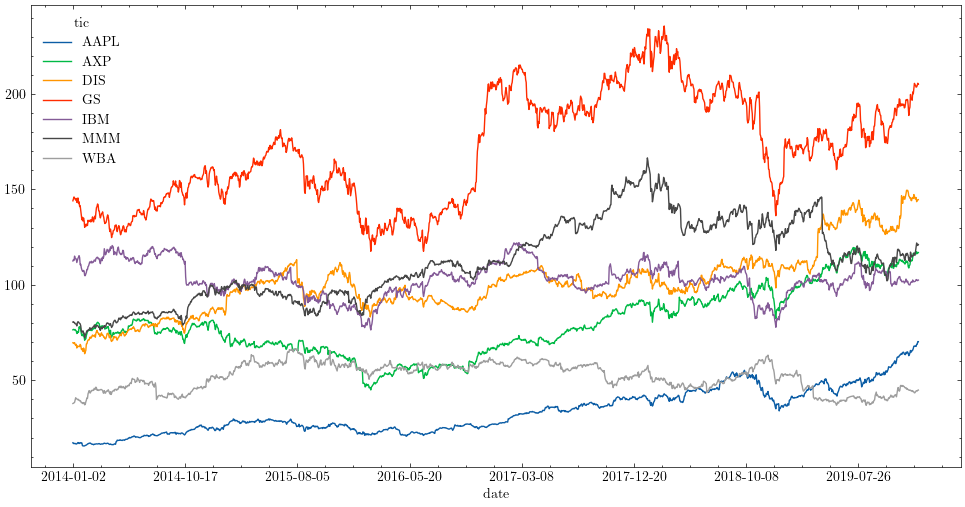

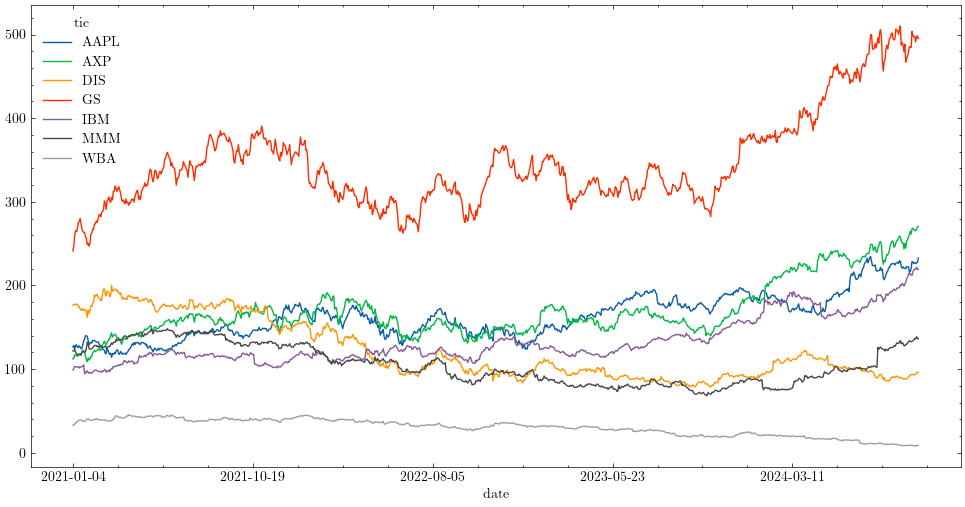

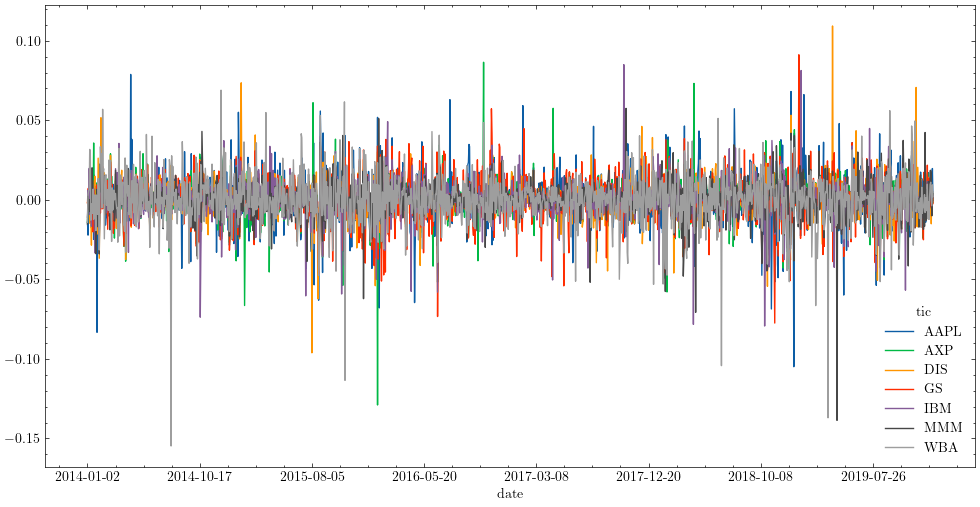

In [11]:
data = train_data
%matplotlib inline
with plt.style.context('science','ieee'):
    pv = data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(12,6))
    pv = test_data.pivot(values='close',columns='tic',index='date')
    pv.plot(figsize=(12,6))
    pv = data.pivot(values='log_return',columns='tic',index='date')
    pv.plot(figsize=(12,6))

    

### PPO


![ppo](./screenshots/ppo.png)

assets : ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']

dates : TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

In [7]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema","close_62_ema"]
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dow30_chl',transaction_fee = 0.003,load=True,
                         model_path='./data/history_main_close.close_21_ema.close_62_ema_dow30_chl/best/best_model'
)

Initial portfolio value:250000
Final portfolio value: 334389.4375
Final accumulative portfolio value: 1.33755775
Maximum DrawDown: -0.21096650764847402
Sharpe ratio: 0.5976140495425616
hit end!


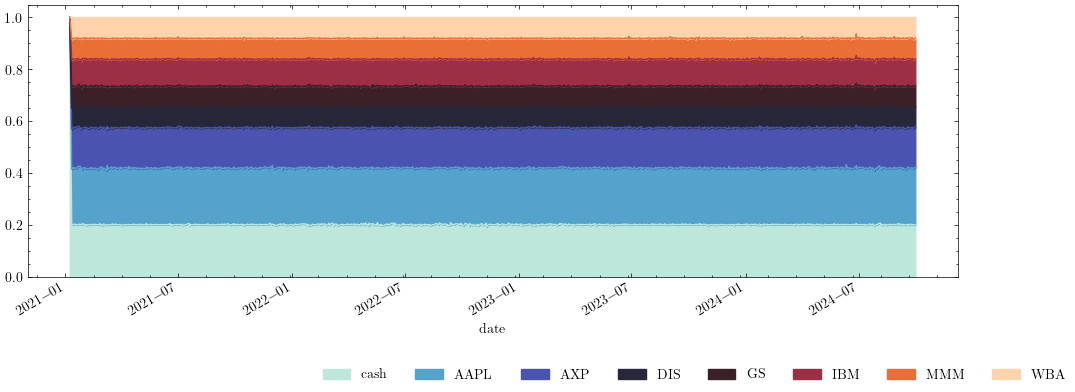

In [8]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns =['cash'] + columns
%matplotlib inline
with plt.style.context('science','ieee'):
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire").legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
    # zz = result_ppo['test'][0]['daily_return']
    # zz.index=result_ppo['test'][0]['date']
    # print('max drowdown:', qs.stats.max_drawdown(result_ppo['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_ppo['test'][0].daily_return))
    # qs.plots.snapshot(zz)


Losts of usesless trades
acting similar to buy and hold but seems overfitted to training
does not seem to capture the trends meaningfully

### PPO SHARPE

![ppo](./screenshots/ppo_sharpe.png)

assets : ['AAPL', 'AXP', 'DIS', 'GS', 'IBM', 'MMM', 'WBA']

dates : TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-10-01'

In [23]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema","close_62_ema"]
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='dow30_sharpe',sharpe_reward=True,transaction_fee = 0.003,
                         load=True,
                         model_path='./data/history_main_close.close_21_ema.close_62_ema_dow30_sharpe/ppo_150000_steps'
)

Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
Normalizing ['close', 'close_21_ema', 'close_62_ema'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 295818.78125
Final accumulative portfolio value: 1.183275125
Maximum DrawDown: -0.23834806705511713
Sharpe ratio: 0.3766148064450469
hit end!


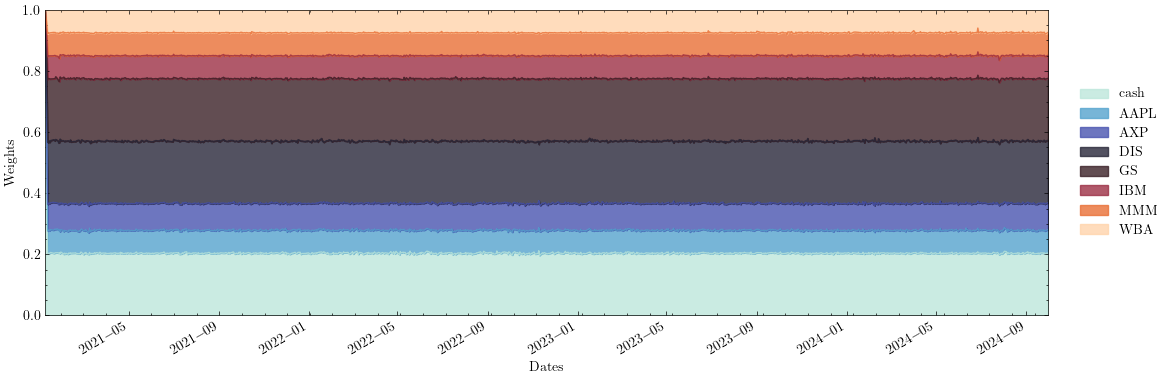

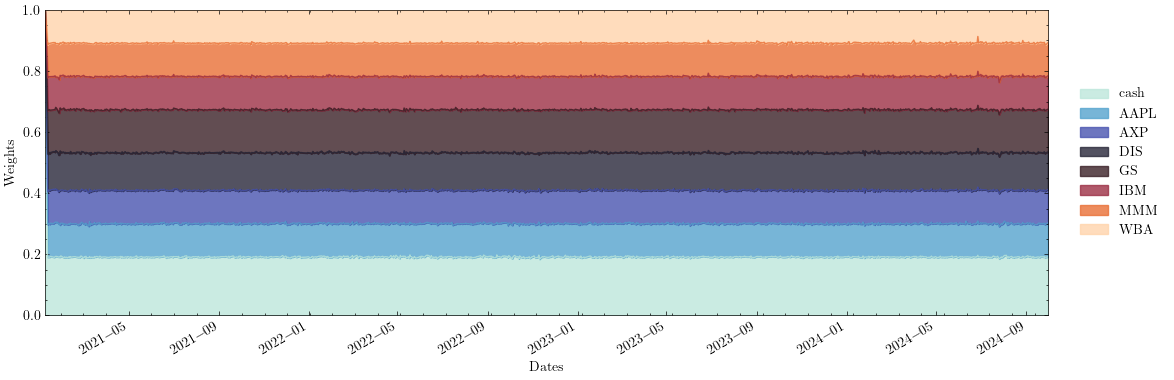

In [24]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()


## PPO without transaction cost

In [ ]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","close_21_ema"]
                         ,iterations=iterations,model_name='ppo',tag='without_fee',transaction_fee = 0
                         ,comission_fee_model = None,
                        load=True,
                         model_path='./data/history_main_close.close_21_ema_without_fee/ppo_110000_steps')

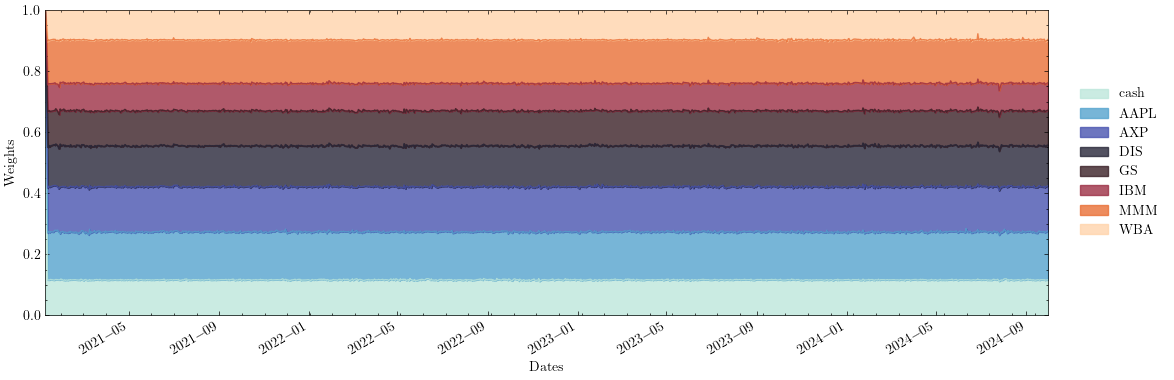

In [28]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()


## PPO high transaction cost

In [75]:
iterations = 1000_000
result_ppo = train_model(train_data,train_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee',transaction_fee = 0.01
                         ,comission_fee_model = "trf"
                         ,load=True,
                         model_path='./data/history_main_close.rsi.atr.macd_high_trading_fee/ppo_500000_steps')

Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 89000.8515625
Final accumulative portfolio value: 0.35600340625
Maximum DrawDown: -0.6605055894586798
Sharpe ratio: -1.259801224123109
hit end!


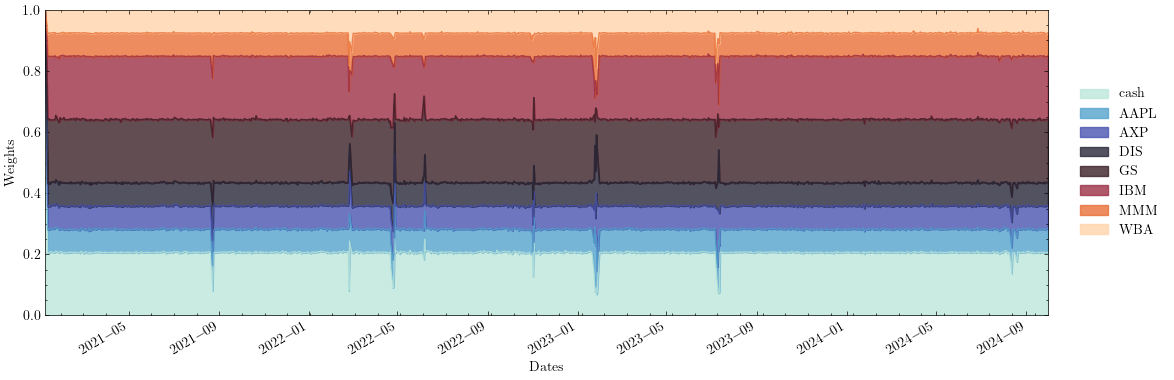

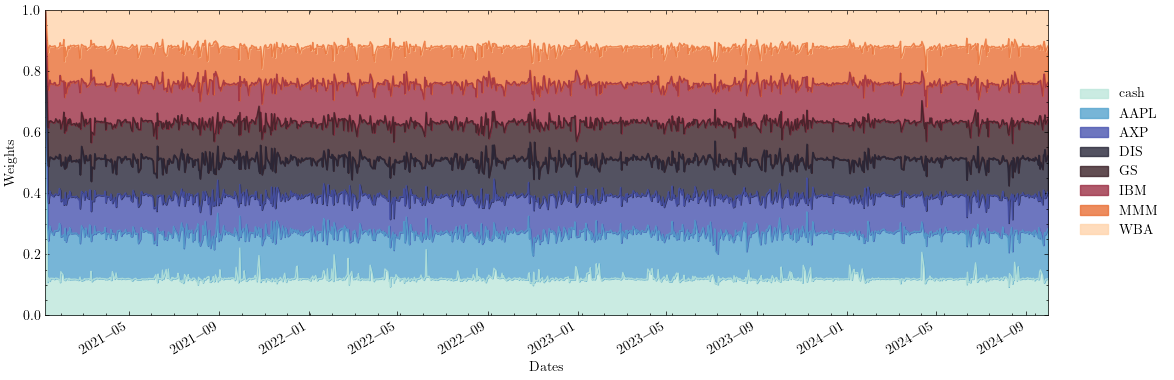

In [15]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()

## MVO

In [8]:
from utils import mvo_data,mvo
correlation_data = mvo_data(cleaned_data,TEST_START_DATE,TEST_END_DATE)


In [9]:
min_variance_portfolio = mvo(correlation_data,pct=0.003)

begin_total_asset:50000
end_total_asset:47648.116117537305
Sharpe:  0.6732666360064377
Test Finished!
episode_return 0.9529623223507461


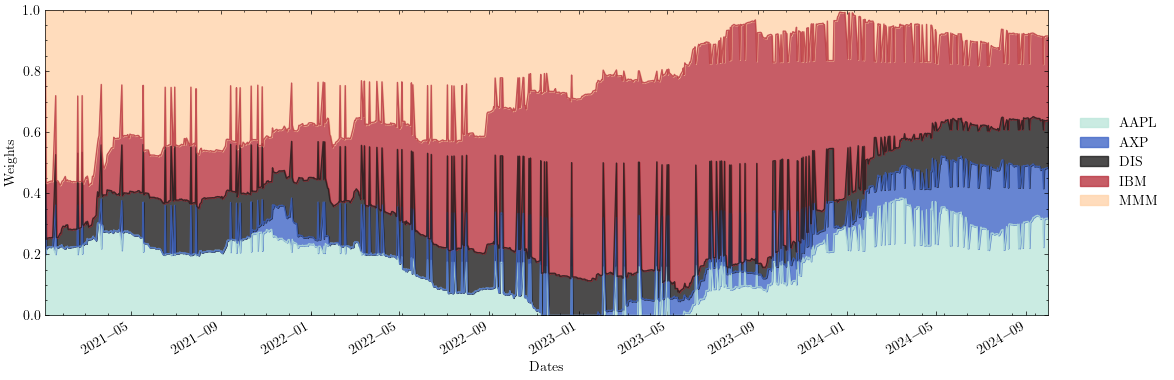

In [10]:
w = pd.DataFrame(min_variance_portfolio['action'])
unique_tics = test_data.tic.unique().tolist()
unique_tics.append('date')
w['date'] = min_variance_portfolio['date']
w.columns = unique_tics
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()
 


In [24]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee',transaction_fee = 0.005
                         ,comission_fee_model = "trf")


Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboardlog_close_rsi_atr_macd_high_trading_fee/ppo_6
Initial portfolio value:250000
Final portfolio value: 18538.318359375
Final accumulative portfolio value: 0.0741532734375
Maximum DrawDown: -0.9276402311885401
Sharpe ratio: -3.091269624435641
-------------------------------------
| rollout/           |              |
|    ep_len_mean     | 1.5e+03      |
|    ep_rew_mean     | -2.6         |
| time/              |              |
|    fps             | 90           |
|    iterations      | 1            |
|    time_elapsed    | 22           |
|    total_timesteps | 2048         |
| train/             |      

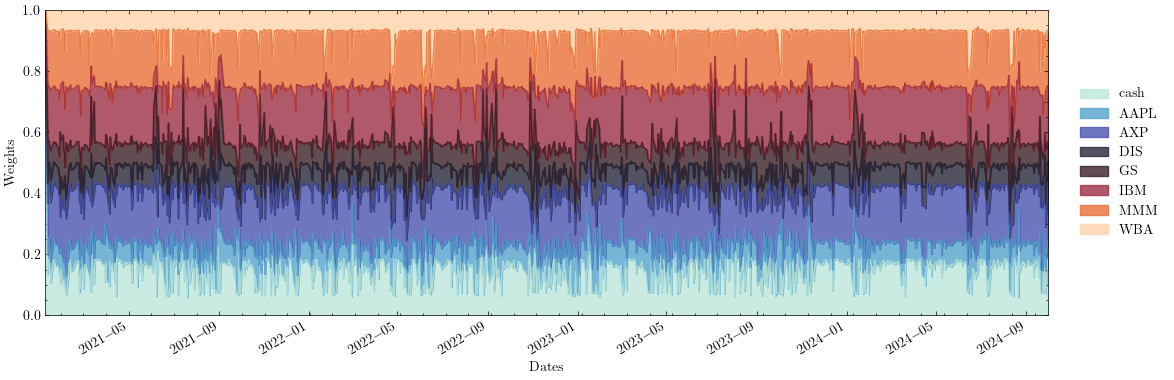

In [25]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()

In [26]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.01
                         ,comission_fee_model = "trf")


Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboardlog_close_rsi_atr_macd_high_trading_fee_0.01/ppo_1
Initial portfolio value:250000
Final portfolio value: 959.8309326171875
Final accumulative portfolio value: 0.00383932373046875
Maximum DrawDown: -0.996172845703125
Sharpe ratio: -6.808694538540017
--------------------------------------
| rollout/           |               |
|    ep_len_mean     | 1.5e+03       |
|    ep_rew_mean     | -5.57         |
| time/              |               |
|    fps             | 92            |
|    iterations      | 1             |
|    time_elapsed    | 22            |
|    total_timesteps | 2048          |
| train/ 

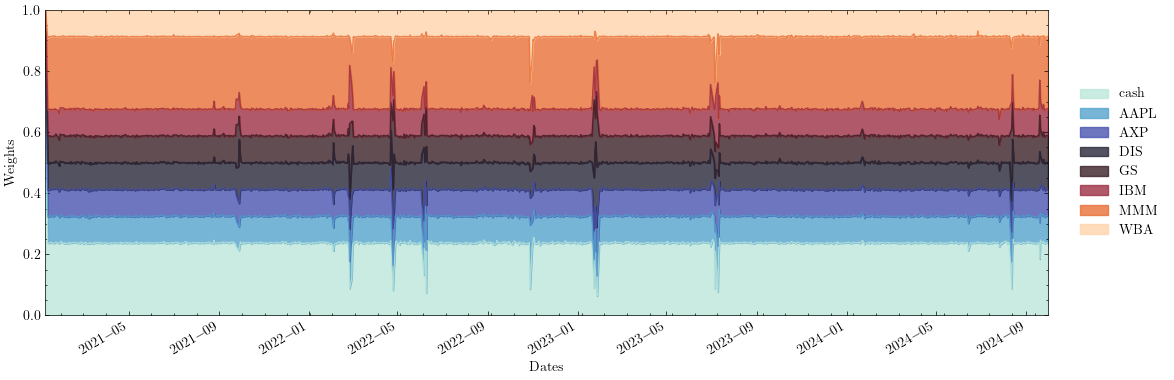

In [27]:
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = ['cash']+columns
%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
    plt.tight_layout()

In [56]:
result_ppo = train_model(train_data,test_data,validation_data,features=["close","rsi","atr","macd"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.01
                         ,comission_fee_model = "trf",load=True,
                         model_path='./data/history_main_close.rsi.atr.macd_high_trading_fee_0.01/ppo_100000_steps')

Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
Normalizing ['close', 'rsi', 'atr', 'macd'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 98602.1953125
Final accumulative portfolio value: 0.39440878125
Maximum DrawDown: -0.6510428970036883
Sharpe ratio: -1.61835376896093
hit end!


In [48]:
train_data

Unnamed: 0        date        open        high         low       close  \
0         164788  2014-01-02   19.845715   19.893929   19.715000   17.234295   
0         164790  2014-01-02   90.900002   91.080002   89.379997   76.407570   
0         164796  2014-01-02   76.040001   76.500000   75.900002   69.643188   
0         164797  2014-01-02  176.949997  178.380005  176.360001  144.011459   
0         164800  2014-01-02  178.977051  179.158707  177.055450  112.504356   
...          ...         ...         ...         ...         ...         ...   
1507      208695  2019-12-27  146.050003  146.509995  145.449997  144.609375   
1507      208697  2019-12-27  231.809998  232.210007  230.470001  205.101898   
1507      208700  2019-12-27  129.063095  129.780121  128.938812  102.484222   
1507      208706  2019-12-27  147.700668  148.444809  146.839462  121.089256   
1507      208715  2019-12-27   58.919998   59.029999   58.380001   44.873989   

         volume   tic  day        rsi        atr      macd    return  \
0     234684800  AAPL    3  51.109696   2.666627  0.174288 -0.014064   
0       5112000   AXP    3  67.669535  13.247325  1.501654 -0.014108   
0       5200900   DIS    3  76.622818   7.212648  1.698749 -0.001702   
0       1982100    GS    3  68.670074  33.284339  2.422669 -0.002087   
0       4755639   IBM    3  61.213005  64.581345  1.140805 -0.010875   
...         ...   ...  ...        ...        ...       ...       ...   
1507    5495300   DIS    4  52.273497   2.757997  0.844042  0.000343   
1507    1343900    GS    4  64.438722  27.014655  3.169829 -0.002379   
1507    2878801   IBM    4  54.540474  27.541681  0.130318  0.002669   
1507    1761588   MMM    4  63.258964  27.621366  1.623746  0.003794   
1507    3647600   WBA    4  54.327822  14.671100 -0.058584  0.002037   

      log_return  
0      -0.014163  
0      -0.014208  
0      -0.001703  
0      -0.002089  
0      -0.010935  
...          ...  
1507    0.000343  
1507   -0.002381  
1507    0.002665  
1507    0.003787  
1507    0.002035  

[10556 rows x 14 columns]

In [28]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close"]
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.005
                         ,comission_fee_model = "trf")


Normalizing ['close'] by previous time...
Normalizing ['close'] by previous time...
Normalizing ['close'] by previous time...
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tensorboardlog_close_high_trading_fee_0.01/ppo_1
Initial portfolio value:250000
Final portfolio value: 20645.64453125
Final accumulative portfolio value: 0.082582578125
Maximum DrawDown: -0.918085109375
Sharpe ratio: -3.0309048243398897
--------------------------------------
| rollout/           |               |
|    ep_len_mean     | 1.5e+03       |
|    ep_rew_mean     | -2.49         |
| time/              |               |
|    fps             | 100           |
|    iterations      | 1             |
|    time_elapsed    | 20            |
|    total_timesteps | 2048          |
| train/             |               |
|    reward          | -0.0071266317 |
--------------------

In [ ]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return"],t=21
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.01
                         ,comission_fee_model = "wvm",normalize=None)


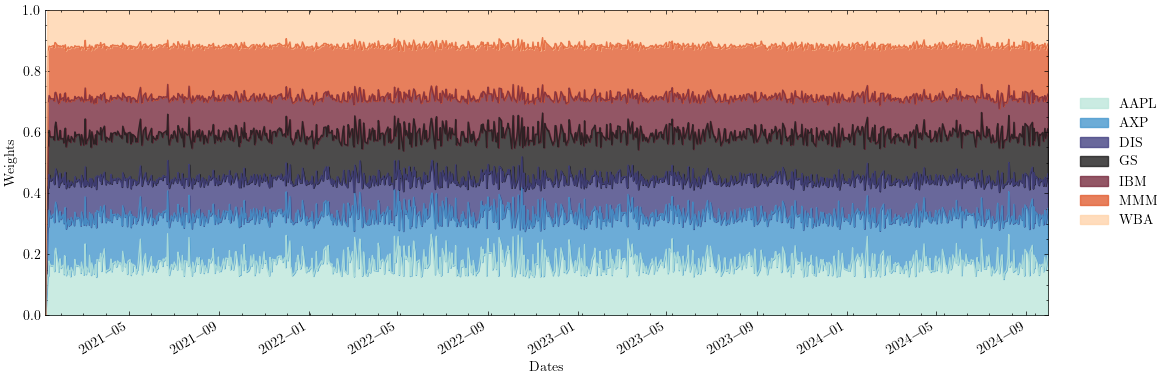

In [46]:
plot_wights(result_ppo)

In [52]:
result_ppo = train_model(train_data,train_data,validation_data,features=["close","log_return"],t=21
                         ,iterations=iterations,model_name='ppo',tag='high_trading_fee_0.01',transaction_fee = 0.01
                         ,comission_fee_model = "wvm",normalize=None
                         ,load=True,
                         model_path='./data/history_main_close.log_return_high_trading_fee_0.01/ppo_100000_steps')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 73111.828125
Final accumulative portfolio value: 0.2924473125
Maximum DrawDown: -0.739623463169869
Sharpe ratio: -1.3172909981750076
hit end!


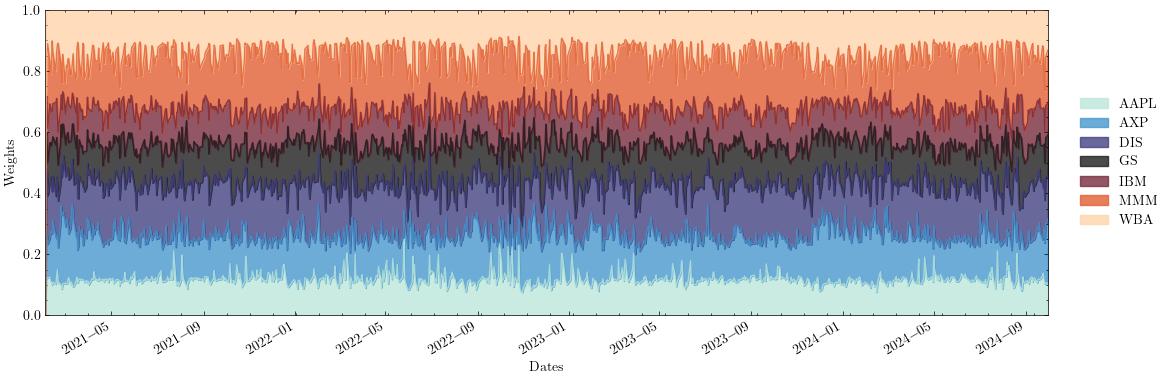

In [51]:
plot_wights(result_ppo)

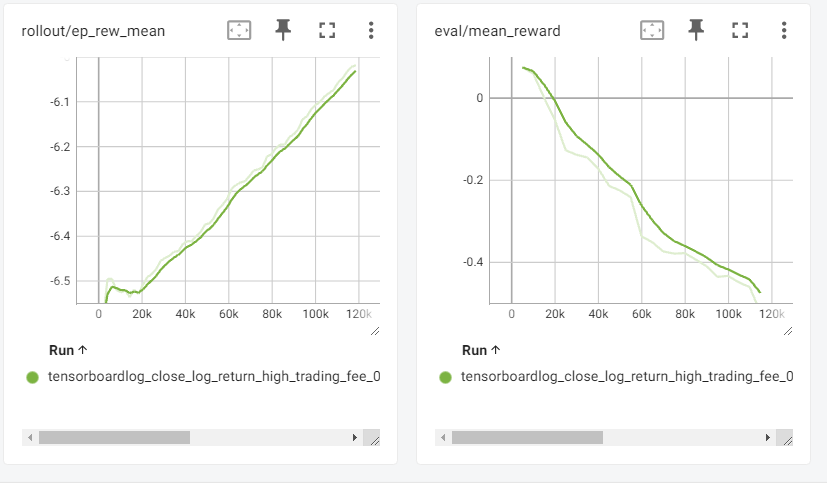

In [51]:
cleaned_data

Unnamed: 0        date        open        high         low       close  \
0          157480  2013-01-02   19.779285   19.821428   19.343929   16.687334   
2956       157482  2013-01-02   58.330002   58.950001   58.310001   49.732204   
5912       157488  2013-01-02   50.799999   51.250000   50.639999   46.091091   
8868       157489  2013-01-02  131.300003  131.660004  129.619995  105.793983   
11824      157492  2013-01-02  185.554489  187.715103  185.277252  116.799042   
...           ...         ...         ...         ...         ...         ...   
8867       244575  2024-09-30   96.849998   97.570000   95.440002   96.190002   
11823      244577  2024-09-30  494.890015  496.519989  488.899994  495.109985   
14779      244580  2024-09-30  220.649994  221.320007  219.020004  219.351273   
17735      244586  2024-09-30  137.830002  137.949997  135.229996  135.976822   
20691      244595  2024-09-30    9.130000    9.290000    8.940000    8.695849   

          volume   tic  day        rsi        atr      macd    return  \
0      560518000  AAPL    2   0.000000   3.134094  0.000000 -0.012622   
2956     6091400   AXP    2   0.000000   9.217796  0.000000 -0.012622   
5912    11674700   DIS    2   0.000000   5.158909  0.000000 -0.012622   
8868     4449000    GS    2   0.000000  25.866020  0.000000 -0.012622   
11824    4428869   IBM    2   0.000000  70.916061  0.000000 -0.012622   
...          ...   ...  ...        ...        ...       ...       ...   
8867     7982300   DIS    0  70.604631   1.567776  1.397734  0.001875   
11823    1602500    GS    0  52.784982  11.134203  2.189769 -0.006820   
14779    3543400   IBM    0  72.574342   4.410235  6.649522  0.001087   
17735    3814000   MMM    0  63.041274   2.787133  2.954818 -0.004370   
20691   20239900   WBA    0  45.760839   0.542935 -0.321303 -0.011038   

       log_return  volatility  annualized_volatility  
0       -0.012702    0.000000               0.000000  
2956    -0.012702    0.000000               0.000000  
5912    -0.012702    0.000000               0.000000  
8868    -0.012702    0.000000               0.000000  
11824   -0.012702    0.000000               0.000000  
...           ...         ...                    ...  
8867     0.001873    0.007896               0.125352  
11823   -0.006844    0.019018               0.301907  
14779    0.001086    0.010471               0.166227  
17735   -0.004380    0.012471               0.197967  
20691   -0.011099    0.024953               0.396116  

[20692 rows x 16 columns]

In [8]:
train_data

Unnamed: 0        date        open        high         low       close  \
0         164788  2014-01-02   19.845715   19.893929   19.715000   17.234295   
0         164790  2014-01-02   90.900002   91.080002   89.379997   76.407570   
0         164796  2014-01-02   76.040001   76.500000   75.900002   69.643188   
0         164797  2014-01-02  176.949997  178.380005  176.360001  144.011459   
0         164800  2014-01-02  178.977051  179.158707  177.055450  112.504356   
...          ...         ...         ...         ...         ...         ...   
1507      208687  2019-12-27   72.779999   73.492500   72.029999   70.239014   
1507      208689  2019-12-27  125.839996  125.970001  125.110001  116.871704   
1507      208695  2019-12-27  146.050003  146.509995  145.449997  144.609375   
1507      208697  2019-12-27  231.809998  232.210007  230.470001  205.101898   
1507      208700  2019-12-27  129.063095  129.780121  128.938812  102.484222   

         volume   tic  day        rsi        atr      macd    return  \
0     234684800  AAPL    3  51.109696   2.666627  0.174288 -0.014064   
0       5112000   AXP    3  67.669535  13.247325  1.501654 -0.014108   
0       5200900   DIS    3  76.622818   7.212648  1.698749 -0.001702   
0       1982100    GS    3  68.670074  33.284339  2.422669 -0.002087   
0       4755639   IBM    3  61.213005  64.581345  1.140805 -0.010875   
...         ...   ...  ...        ...        ...       ...       ...   
1507  146266000  AAPL    4  78.449779   2.759339  1.811762 -0.000379   
1507    1788600   AXP    4  62.475306   9.053394  1.484339 -0.001754   
1507    5495300   DIS    4  52.273497   2.757997  0.844042  0.000343   
1507    1343900    GS    4  64.438722  27.014655  3.169829 -0.002379   
1507    2878801   IBM    4  54.540474  27.541681  0.130318  0.002669   

      log_return  
0      -0.014163  
0      -0.014208  
0      -0.001703  
0      -0.002089  
0      -0.010935  
...          ...  
1507   -0.000380  
1507   -0.001756  
1507    0.000343  
1507   -0.002381  
1507    0.002665  

[7540 rows x 14 columns]

In [21]:
def calc_train_trade_starts_ends_if_rolling(
    init_train_dates: list[str], init_trade_dates: list[str], rolling_window_length: int
) -> tuple[list[str], list[str], list[str], list[str]]:
    trade_dates_length = len(init_trade_dates)
    train_window_length = len(init_train_dates)
    trade_window_length = min(rolling_window_length, trade_dates_length)
    num_subsets_if_rolling = int(np.ceil(trade_dates_length / trade_window_length))
    print("num_subsets_if_rolling: ", num_subsets_if_rolling)
    dates = np.concatenate((init_train_dates, init_trade_dates), axis=0)
    train_starts = []
    train_ends = []
    trade_starts = []
    trade_ends = []

    for i in range(num_subsets_if_rolling):
        trade_start_index = train_window_length + i * trade_window_length
        trade_start = dates[trade_start_index]
        trade_starts.append(trade_start)
        trade_end_index = min(trade_start_index + trade_window_length, len(dates) - 1)
        trade_end = dates[trade_end_index]
        trade_ends.append(trade_end)
        train_start = dates[trade_start_index - train_window_length]
        train_starts.append(train_start)
        train_end = dates[trade_start_index]
        train_ends.append(train_end)
    print("train_starts: ", train_starts)
    print("train_ends__: ", train_ends)
    print("trade_starts: ", trade_starts)
    print("trade_ends__: ", trade_ends)
    return train_starts, train_ends, trade_starts, trade_ends


KeyboardInterrupt: 

In [39]:
from finrl.meta.data_processors.func import calc_train_trade_data
date_col = 'date'
rolling_window_length = 252
init_train_dates = train_data[date_col].unique()
init_trade_dates = test_data[date_col].unique()
(
    train_starts,
    train_ends,
    trade_starts,
    trade_ends,
) = calc_train_trade_starts_ends_if_rolling(
    init_train_dates, init_trade_dates, rolling_window_length
)
len(train_starts)
ongoing_model = None
model_name = 'ppo'
tag = 'rolling_window'
iterations = 50000
for i in range(len(train_starts)):
    print("i: ", i)
    train_data_, trade_data_ = calc_train_trade_data(
        i,
        train_starts,
        train_ends,
        trade_starts,
        trade_ends,
        train_data,
        test_data,
        date_col,
    )
    if ongoing_model == None:
        ongoing_model = train_model(train_data_,trade_data_,validation_data,features=["close","log_return","volatility"],t=5
                            ,iterations=iterations,model_name=model_name,tag=tag,transaction_fee = 0.01
                            ,comission_fee_model = "wvm",normalize=None)
    else:
        ongoing_model = train_model(train_data_,trade_data_,validation_data,features=["close","log_return","volatility"],t=5
                    ,iterations=iterations,model_name=model_name,tag=tag,transaction_fee = 0.01
                    ,comission_fee_model = "wvm",normalize=None,load_continue=True
                    ,model_path='./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag)

Initial portfolio value:250000
Final portfolio value: 437.62255859375
Final accumulative portfolio value: 0.001750490234375
Maximum DrawDown: -0.9982522290039062
Sharpe ratio: -6.075736353850785
-------------------------------------
| rollout/           |              |
|    ep_len_mean     | 1.5e+03      |
|    ep_rew_mean     | -6.99        |
| time/              |              |
|    fps             | 66           |
|    iterations      | 18           |
|    time_elapsed    | 552          |
|    total_timesteps | 36864        |
| train/             |              |
|    reward          | -0.013012967 |
-------------------------------------
Initial portfolio value:250000
Final portfolio value: 404.7562561035156
Final accumulative portfolio value: 0.0016190250244140624
Maximum DrawDown: -0.998380974975586
Sharpe ratio: -6.287642151824324
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.5e+03       |
|    ep_rew_mean 

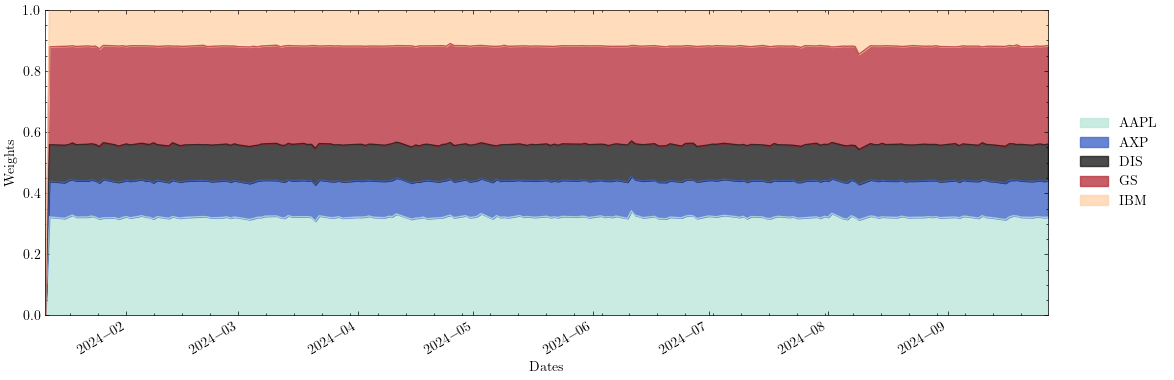

In [43]:
plot_wights(ongoing_model)

In [5]:
train_data

Unnamed: 0        date        open        high         low       close  \
0         164788  2014-01-02   19.845715   19.893929   19.715000   17.234295   
0         164790  2014-01-02   90.900002   91.080002   89.379997   76.407570   
0         164796  2014-01-02   76.040001   76.500000   75.900002   69.643188   
0         164800  2014-01-02  178.977051  179.158707  177.055450  112.504356   
0         164806  2014-01-02  115.426422  116.220734  115.058525   80.494003   
...          ...         ...         ...         ...         ...         ...   
1507      208687  2019-12-27   72.779999   73.492500   72.029999   70.239014   
1507      208689  2019-12-27  125.839996  125.970001  125.110001  116.871704   
1507      208695  2019-12-27  146.050003  146.509995  145.449997  144.609375   
1507      208700  2019-12-27  129.063095  129.780121  128.938812  102.484222   
1507      208706  2019-12-27  147.700668  148.444809  146.839462  121.089256   

         volume   tic  day        rsi        atr    return  log_return  \
0     234684800  AAPL    3  51.109696   2.666627 -0.014064   -0.014163   
0       5112000   AXP    3  67.669535  13.247325 -0.014108   -0.014208   
0       5200900   DIS    3  76.622818   7.212648 -0.001702   -0.001703   
0       4755639   IBM    3  61.213005  64.581345 -0.010875   -0.010935   
0       3650312   MMM    3  68.263584  34.566612 -0.015115   -0.015231   
...         ...   ...  ...        ...        ...       ...         ...   
1507  146266000  AAPL    4  78.449779   2.759339 -0.000379   -0.000380   
1507    1788600   AXP    4  62.475306   9.053394 -0.001754   -0.001756   
1507    5495300   DIS    4  52.273497   2.757997  0.000343    0.000343   
1507    2878801   IBM    4  54.540474  27.541681  0.002669    0.002665   
1507    1761588   MMM    4  63.258964  27.621366  0.003794    0.003787   

      volatility  
0       0.211186  
0       0.154761  
0       0.167403  
0       0.164331  
0       0.178959  
...          ...  
1507    0.171655  
1507    0.161385  
1507    0.113850  
1507    0.094431  
1507    0.230276  

[7540 rows x 14 columns]

['AAPL', 'AXP', 'DIS', 'MMM', 'IBM']

In [39]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                         ,transaction_fee = 0.001,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset/ppo_800000_steps')


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 360453.125
Final accumulative portfolio value: 1.4418125
Maximum DrawDown: -0.21844821681182136
Sharpe ratio: 0.7047697839549554
hit end!


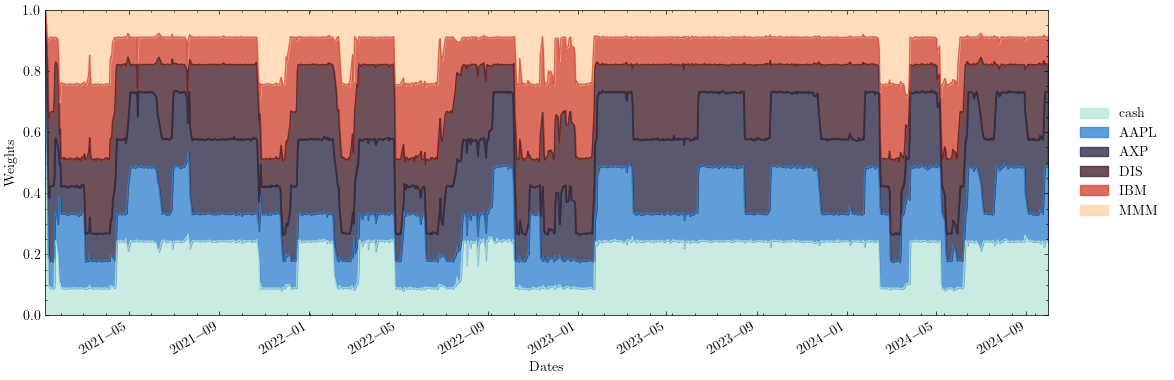

In [40]:
plot_weights(result_ppo,True,test_data)

In [15]:
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize=None
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                         ,transaction_fee = 0.003,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset/ppo_50000_steps')

NameError: name 'iterations' is not defined

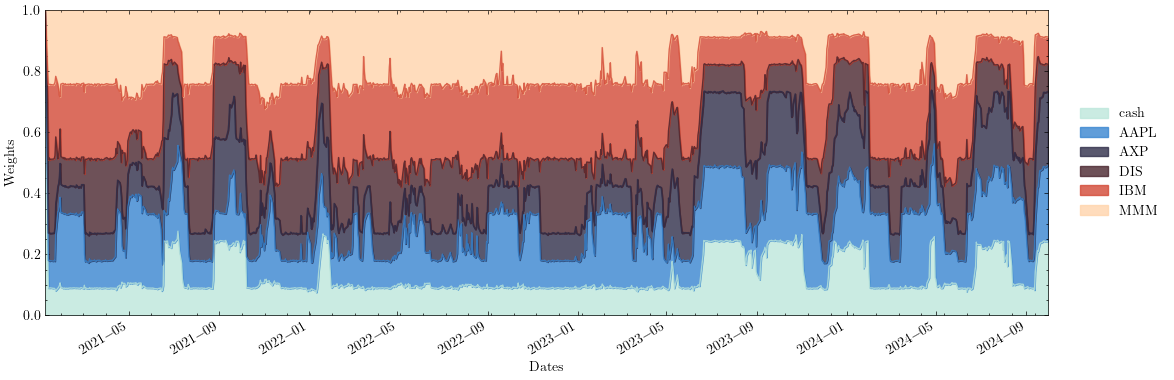

In [23]:
plot_weights(result_ppo,True)

In [45]:
iterations = 1000_000
result_ppo_3 = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility","rsi","atr"],normalize=None
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                        ,transaction_fee = 0.003,load=True,model_path='./data/history_main_close.log_return.volatility.rsi.atr_5_asset/ppo_500000_steps')


{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Initial portfolio value:250000
Final portfolio value: 292853.53125
Final accumulative portfolio value: 1.171414125
Maximum DrawDown: -0.2441995533835677
Sharpe ratio: 0.36002105388466105
hit end!


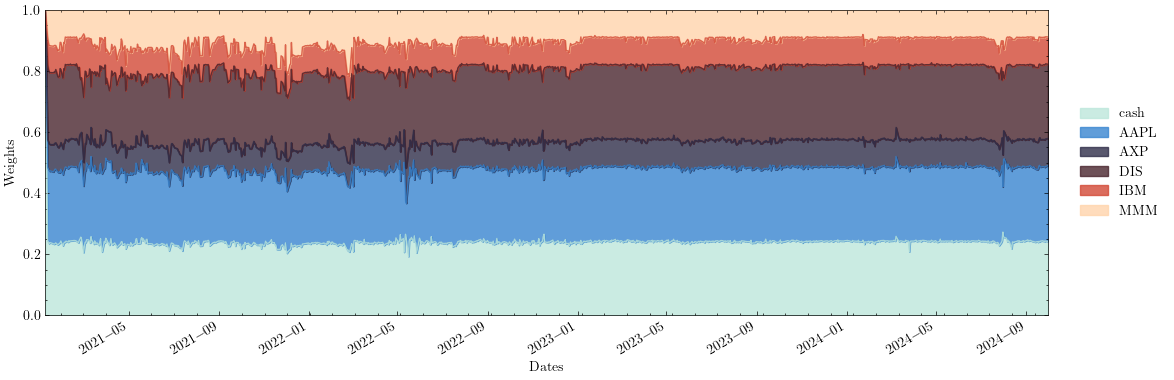

In [46]:
plot_weights(result_ppo_3,True,test_data)

High trading fee , normalize state

In [ ]:
iterations = 1000_000
result_ppo = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility"],normalize="by_previous_time"
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                         ,transaction_fee = 0.001,load=True,model_path='./data/history_main_close.log_return.volatility_5_asset/ppo_800000_steps')

Indicators. not normalized

In [ ]:
iterations = 1000_000
result_ppo_3 = train_model(train_data,test_data,validation_data,features=["close","log_return","volatility","rsi","atr"]
                         ,iterations=iterations,comission_fee_model='trf',model_name='ppo',tag='5_asset'
                         ,transaction_fee = 0.003
)

In [16]:
stock_dimension = len(test_data.tic.unique()) +1

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0.003,
    time_window=5,
    features = ["close","return"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1398714.25
Final accumulative portfolio value: 1.39871425
Maximum DrawDown: -0.2245954406113726
Sharpe ratio: 0.6603069356189577


In [22]:
environment_train_buy_and_hold._final_weights

[array([1., 0., 0., 0., 0., 0.], dtype=float32),
 array([0.16764617, 0.1637486 , 0.16665496, 0.16802144, 0.1677114 ,
        0.1662174 ], dtype=float32),
 array([0.16670138, 0.16646871, 0.16747254, 0.16381584, 0.16751815,
        0.16802332], dtype=float32),
 array([0.16654801, 0.16925055, 0.16761614, 0.16667104, 0.16359632,
        0.16631797], dtype=float32),
 array([0.1667276 , 0.16420546, 0.16860737, 0.16418107, 0.16942054,
        0.16685796], dtype=float32),
 array([0.16801184, 0.16570497, 0.16579938, 0.16608399, 0.16725625,
        0.16714354], dtype=float32),
 array([0.16462694, 0.16552037, 0.17082657, 0.16541435, 0.16543472,
        0.16817705], dtype=float32),
 array([0.1646669 , 0.17007722, 0.16751204, 0.16598608, 0.16601978,
        0.16573796], dtype=float32),
 array([0.16594566, 0.17202891, 0.16400228, 0.16369024, 0.16794854,
        0.16638437], dtype=float32),
 array([0.16931626, 0.17203784, 0.16760223, 0.17079906, 0.1525454 ,
        0.16769917], dtype=float32),
 array

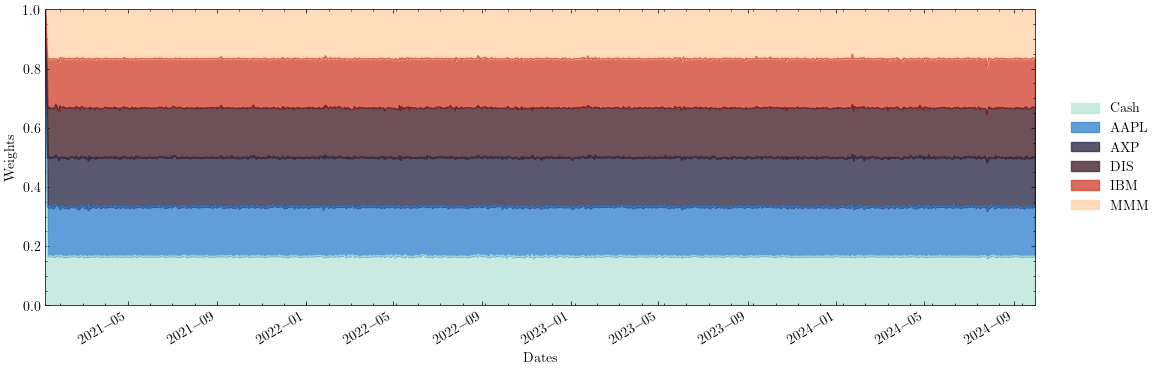

In [25]:
w = pd.DataFrame(environment_train_buy_and_hold._final_weights)
columns = test_data.tic.unique().tolist()
columns.append('date')
w['date'] = environment_train_buy_and_hold._date_memory
w.columns = ['Cash']+columns

%matplotlib inline
with plt.style.context('science','ieee'):
    fig, (ax_main, ax_legend) = plt.subplots(
        ncols=2, 
        gridspec_kw={'width_ratios': [10, 1]},  # Adjust width ratios
        figsize=(12, 6)
    )
    w.plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="icefire",ax=ax_main, alpha=0.8)
    ax_main.set_xlim(w.date.min(), w.date.max())
    ax_main.set_ylim(0, 1)
    ax_main.set_ylabel('Weights')
    ax_main.set_xlabel('Dates')
    ax_legend.axis('off')
    handles, labels = ax_main.get_legend_handles_labels()
    ax_main.legend().remove()
    ax_legend.legend(handles, labels, loc='center', ncol=1)  # Adjust ncol for horizontal legend
plt.tight_layout()